In [62]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [63]:
def get_card():
    card = np.random.randint(1, TYPE_OF_CARDS+1)
    return min(card, 10)

def before_decision(player):
    assert len(player) == 2
    sump, usable_ace = sum_hands(player)

    while sump < 12:
        player.append(get_card())
        sump, usable_ace = sum_hands(player)

    return player, sump, usable_ace

def sum_hands(cards):
    s = sum(cards)
    usable_ace = 0
    if 1 in cards and s+10 <= 21:
        s += 10
        usable_ace = 1
    return s, usable_ace
        
def plot_v(v, usable_ace):
    fig = plt.figure(figsize=(8,4))
    ax = Axes3D(fig)
    # x, y = np.meshgrid(12:22, 1:11)
    x, y = np.mgrid[12:22, 1:11]
    ax.plot_surface(x, y, v[:,:,usable_ace], rstride=1, cstride=1, cmap='gray')
    ax.set_xlabel('sum of the first several cards of the player') 
    ax.set_ylabel('dealer\'s showing card')
    ax.set_zlabel('evaluation')
    ax.view_init(30, -150) #'elev' stores the elevation angle in the z plane. 'azim' stores the azimuth angle in the x,y plane
    if usable_ace:
        plt.title('usable_ace')
    else:
        plt.title('no usable_ace')
        plt.show()

## Figure 5.1: approximate state-value functions for the policy that sticks only on 20 or 21

In [64]:
def play_cards(player, dealer):
    sump, _ = sum_hands(player)
    sumd, _ = sum_hands(dealer)
    assert sump <= 21
    assert sumd <= 21
    
    ### player: sticks only on 20 or 21 ####
    while sump < 20:
        player.append(get_card())
        sump, _ = sum_hands(player)

    ### dealer: sticks on any sum of 17 or greater  ###
    while sumd < 17:
        dealer.append(get_card())
        sumd, _ = sum_hands(dealer)

    if sump > 21:
        return -1            # lose
    elif sumd > 21:
        return 1            # win
    else:
        return np.sign(sump - sumd)       # both not go bust

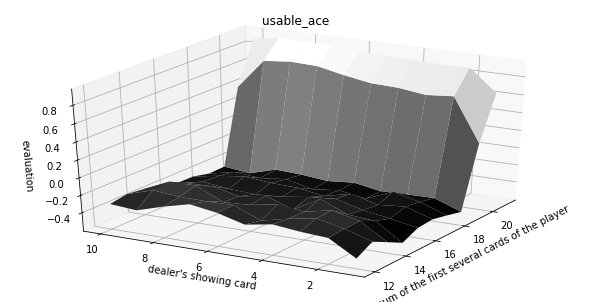

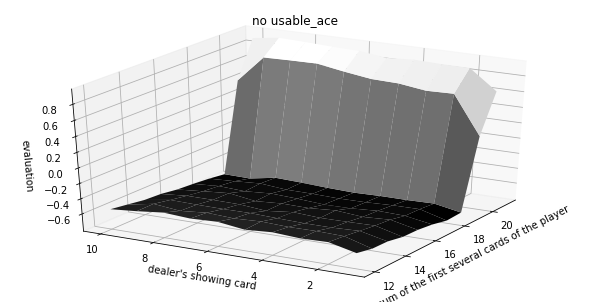

In [65]:
NUMBER_OF_GAMES = 500000
TYPE_OF_CARDS = 13
v = np.zeros((10,10,2))
n_visit = np.zeros((10,10,2))                              # 12-21,1-10,usable_ace

for i in range(NUMBER_OF_GAMES):
    player = [get_card(), get_card()]
    dealer = [get_card(), get_card()]
    
    player, sump, usable_ace = before_decision(player)
    showing_card = dealer[0]
    play_result = play_cards(player, dealer)
    n_visit[sump-12, showing_card-1, usable_ace] += 1
    v[sump-12, showing_card-1, usable_ace] += (play_result - v[sump-12, showing_card-1, usable_ace])/n_visit[sump-12, showing_card-1, usable_ace]

##### plot the figure on page 94 # ###
plot_v(v, usable_ace=1)
plot_v(v, usable_ace=0)

## Monte Carlo ES(exploring starts)

In [68]:
def play_cards2(player, dealer, showing_card, q_table):
    sump, usable_ace = sum_hands(player)
    sumd, _= sum_hands(dealer)
    assert sump <= 21
    assert sumd <= 21
    
    ### player: action is 1 when hits otherwise 0 ###
    player_states = [sump]
    usable_aces = [usable_ace]
    action = 1 if q_table[sump-12, showing_card-1, usable_ace, 1] >= q_table[sump-12, showing_card-1, usable_ace, 0] else 0
    if np.random.random() < EPSILON:
        action = 1 - action
    actions = [action]
    
    while action:
        player.append(get_card())
        sump, usable_ace = sum_hands(player)
        player_states.append(sump)
        usable_aces.append(usable_ace)
        if sump <= 21:
            #### choose the bigger action-value with big posibility
            if np.random.random() > EPSILON:
                action = 1 if q_table[sump-12, showing_card-1, usable_ace, 1] >= \
                    q_table[sump-12, showing_card-1, usable_ace, 0] else 0
            else:
                action = 0 if q_table[sump-12, showing_card-1, usable_ace, 1] >= \
                    q_table[sump-12, showing_card-1, usable_ace, 0] else 1
            actions.append(action)
        else:
            action = 0
            player_states.pop()
            usable_aces.pop()

    ### dealer: sticks on any sum of 17 or greater ###
    while sumd < 17:
        dealer.append(get_card())
        sumd, _ = sum_hands(dealer)

    if sump > 21:
        res = -1            # lose
    elif sumd > 21:
        res = 1             # win
    else:
        res = np.sign(sump - sumd)       # both not go bust
        
    return player_states, usable_aces, actions, res

In [211]:
def play_cards3(player, dealer, showing_card, q_table):
    sump, usable_ace = sum_hands(player)
    sumd, _= sum_hands(dealer)
    assert sump <= 21
    assert sumd <= 21
    
    ### player: action is 1 when hits otherwise 0 ###
    player_states = [sump]
    usable_aces = [usable_ace]
    
    action = np.random.randint(2)
    actions = [action]
    
    while action:
        player.append(get_card())
        sump, usable_ace = sum_hands(player)
        player_states.append(sump)
        usable_aces.append(usable_ace)
        if sump <= 21:
            #### choose the bigger action-value with big posibility
            action = np.random.randint(2)
            actions.append(action)
        else:
            action = 0
            player_states.pop()
            usable_aces.pop()

    ### dealer: sticks on any sum of 17 or greater ###
    while sumd < 17:
        dealer.append(get_card())
        sumd, _ = sum_hands(dealer)

    if sump > 21:
        res = -1            # lose
    elif sumd > 21:
        res = 1             # win
    else:
        res = np.sign(sump - sumd)       # both not go bust
        
    return player_states, usable_aces, actions, res

In [277]:
EPISODES = 5000000
TYPE_OF_CARDS = 13
q_table = np.zeros((10,10,2,2))        # 12-21,1-10,usable_ace,stick or hit
n_visit = np.zeros((10,10,2,2), dtype=int)                    # 12-21,1-10,usable_ace,stick or hit
MIN_EPSILON = 0.1

for episode in range(EPISODES):
#     epsilon = 1 - episode/EPISODES
    player = [get_card(), get_card()]
    dealer = [get_card(), get_card()]

    player, sump, _ = before_decision(player)
    showing_card = dealer[0]
    p_states, usable_aces, actions, play_result = play_cards3(player, dealer, showing_card, q_table)
    
    for state, usable_ace, action in zip(p_states, usable_aces, actions):
        n_visit[state-12, showing_card-1, usable_ace, action] += 1
#         q_table[state-12, showing_card-1, usable_ace, action] += (play_result - \
#             q_table[state-12, showing_card-1, usable_ace, action])/n_visit[state-12, showing_card-1, usable_ace, action]
        q_table[state-12, showing_card-1, usable_ace, action] += play_result
q_table = q_table/n_visit

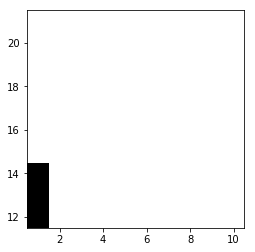

In [278]:
usable_ace = 0
g = q_table[:, :, usable_ace, 1] >= q_table[:, :, usable_ace, 0]
plt.imshow(g, cmap='Greys', origin='lower', extent=[0.5,10.5,11.5,21.5])

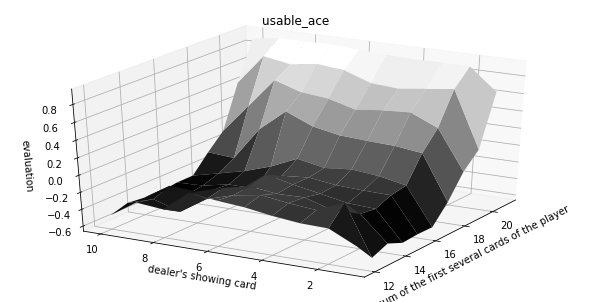

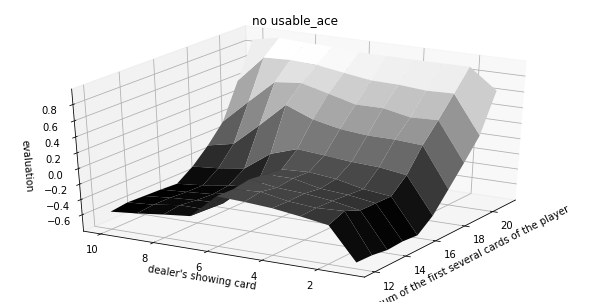

In [223]:
v = np.maximum(q_table[:,:,:,0], q_table[:,:,:,1])
plot_v(v, usable_ace=1)
plot_v(v, usable_ace=0)

In [222]:
np.round(q_table[:, :, usable_ace, 0],3)

array([[-0.749, -0.313, -0.257, -0.209, -0.183, -0.166, -0.477, -0.512,
        -0.553, -0.586],
       [-0.744, -0.229, -0.246, -0.216, -0.148, -0.17 , -0.488, -0.485,
        -0.533, -0.558],
       [-0.794, -0.317, -0.25 , -0.21 , -0.189, -0.134, -0.502, -0.514,
        -0.536, -0.567],
       [-0.764, -0.321, -0.267, -0.239, -0.162, -0.162, -0.451, -0.528,
        -0.552, -0.575],
       [-0.782, -0.326, -0.285, -0.208, -0.17 , -0.187, -0.483, -0.504,
        -0.557, -0.589],
       [-0.619, -0.144, -0.093, -0.076, -0.043, -0.013, -0.125, -0.37 ,
        -0.42 , -0.448],
       [-0.367,  0.15 ,  0.174,  0.177,  0.21 ,  0.285,  0.421,  0.111,
        -0.182, -0.254],
       [-0.112,  0.385,  0.371,  0.441,  0.44 ,  0.53 ,  0.618,  0.585,
         0.287, -0.02 ],
       [ 0.152,  0.637,  0.628,  0.656,  0.665,  0.715,  0.768,  0.788,
         0.773,  0.434],
       [ 0.64 ,  0.894,  0.891,  0.892,  0.895,  0.896,  0.922,  0.933,
         0.951,  0.887]])

In [220]:
np.round(q_table[:, :, usable_ace, 1] - q_table[:, :, usable_ace, 0],3)

array([[ 0.013, -0.202, -0.273, -0.332, -0.311, -0.314, -0.06 , -0.062,
        -0.046, -0.077],
       [-0.007, -0.369, -0.338, -0.349, -0.391, -0.395, -0.058, -0.131,
        -0.103, -0.125],
       [ 0.018, -0.319, -0.356, -0.422, -0.429, -0.469, -0.113, -0.133,
        -0.13 , -0.149],
       [-0.026, -0.36 , -0.411, -0.402, -0.481, -0.477, -0.208, -0.119,
        -0.121, -0.175],
       [-0.033, -0.365, -0.415, -0.47 , -0.52 , -0.536, -0.207, -0.188,
        -0.174, -0.171],
       [-0.221, -0.615, -0.687, -0.649, -0.707, -0.731, -0.593, -0.358,
        -0.325, -0.346],
       [-0.48 , -0.94 , -0.935, -0.981, -1.016, -1.086, -1.22 , -0.906,
        -0.621, -0.573],
       [-0.792, -1.235, -1.251, -1.279, -1.305, -1.365, -1.472, -1.452,
        -1.146, -0.842],
       [-1.086, -1.571, -1.544, -1.58 , -1.583, -1.637, -1.685, -1.719,
        -1.697, -1.363],
       [-1.64 , -1.894, -1.891, -1.892, -1.895, -1.896, -1.922, -1.933,
        -1.951, -1.887]])

In [272]:
n_visit[:,:,usable_ace,0]

array([[ 22019,  21944,  22158,  22247,  21981,  22205,  22100,  21971,
         22126,  87767],
       [ 21649,  21601,  21628,  22215,  22113,  21749,  21873,  21606,
         21818,  87665],
       [ 21903,  21858,  21800,  21899,  21989,  21876,  21927,  21852,
         21705,  87099],
       [ 21636,  21767,  21899,  21421,  21634,  21755,  21644,  21484,
         21773,  85957],
       [ 21375,  21432,  21217,  21259,  21302,  21400,  21227,  21261,
         21259,  85189],
       [ 20923,  20904,  20904,  21019,  20870,  21032,  20759,  21129,
         20840,  83830],
       [ 20468,  20730,  20286,  20040,  20434,  20685,  20778,  20810,
         20418,  82148],
       [ 19917,  20052,  19787,  19883,  20033,  19902,  20041,  19866,
         19810,  79553],
       [ 29623,  29270,  29486,  29429,  29455,  29489,  28899,  29609,
         29379, 117241],
       [ 12664,  12625,  12707,  12749,  12963,  12777,  12670,  12821,
         12853,  50979]])